Vytvořte model lineární regrese pro předpověď šance na přijetí na vysokou školu

In [2]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import OLSInfluence

Dataset : GRE Score (max 340b), TOEFL Score (max 120b), University Rating (1-5), SOP/LOR/CGPA - síla motivačního dopisu a doporučení (1-5), Research - Zkušenost s výzkumem (0/1),
Chance of Admin - šance na přijetí (mezi 0 a 1)

PŘÍPRAVA DAT

1. Načtěte dataset a ujistěte se, že rozumíte hodnotám ve sloupcích. Můžete změnit názvy sloupců a odstranit z nich mezery, což se vám může později hodit.

In [3]:
dataset = pd.read_csv("adm_data.csv")
dataset.columns = dataset.columns.str.replace(' ', '')

data=dataset.rename(columns={"SerialNo.": "ID", "GREScore": "GRE", "TOEFLScore":"TOEFL", "UniversityRating":"UNIRATING","Research":"RESEARCH","ChanceofAdmit":"RESULT"})

data.head()

,ID,GRE,TOEFL,UNIRATING,SOP,LOR,CGPA,RESEARCH,RESULT
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


NORMÁLNOST DAT PRO TOEFL SKÓRE

1. Vypočtěte průměr a medián pro TOEFL skóre
    1a. Průměr
    1b. Medián
2. Vypočítejte směrodatnou odchylku

In [4]:
print(data["TOEFL"].mean()) # ad 1a.
print(data["TOEFL"].median()) # ad 1b.
print(data["TOEFL"].std()) # ad 2.

107.41
107.0
6.069513777374126


Vytvořte histogram pro TOEFL skóre a nezapomeňte zobrazit odhadovanou křivku pravděpodobnostního rozdělení

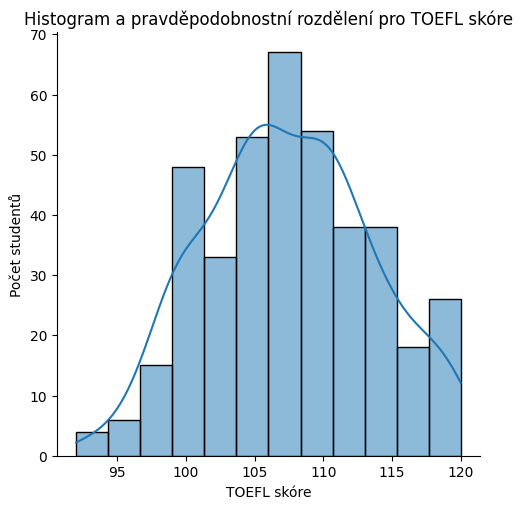

In [5]:
ax=sns.displot(data=data, x="TOEFL", kde=True)

ax.set(xlabel="TOEFL skóre", ylabel="Počet studentů",
       title="Histogram a pravděpodobnostní rozdělení pro TOEFL skóre")

Otestujte, zda je TOEFL skóre vybráno z normálního rozdělení pomocí statistického testu. Uvažujte hladinu ---?

- H0: Data mají normální rozdělení.
- H1: Data nemají normální rozdělení.

In [6]:
stats.normaltest(data["TOEFL"])
#p-hodnota je menší než 0,05 a tudíž (na 5% hladině významnosti) zamítám nulovou hypotézu -> data NEmají normální rozdělení

NormaltestResult(statistic=11.070212103496331, pvalue=0.003945790155853822)

TESTOVÁNÍ HYPOTÉZ

1. Rozdělte data na studenty, kteří mají a nemají zkušenost s výzkumem
2. Pro obě skupiny spočítejte průměrné GRE skóre
3. Statisticky otestujte, zda existuje statisticky významný rozdíl v GRE skóre mezi těmito dvěma skupinami testů. Vyberte správný test a nezapomeňte krátce okomentovat vyhodnocení testu.

In [7]:
data["RESEARCH"].value_counts() #219 má zkušenost, 181 nemá zkušenost

research_yes = data[data["RESEARCH"] == 1] # Ad 1.
research_no = data[data["RESEARCH"] == 0] # Ad 1.

print(research_yes["GRE"].mean())  # Ad 2.
print(research_no["GRE"].mean())  # Ad 2.


322.85388127853884
309.49171270718233


In [8]:
#H0: Neexistuje statisticky významný rozdíl v GRE skóre, bez ohledu na zkušenost studenta s výzkumem.
#H1: Existuje statisticky významný rozdíl v GRE skóre, podle toho zda má student zkušenost s výzkumem.

stats.normaltest(research_yes["GRE"])
stats.normaltest(research_no["GRE"])

# p-hodnota je >0,05 a proto (na 5% hladině významnosti) NEzamítám nulovou hypotézu -> Není žádný statisticky významný rozdíl v GRE podle toho zda student má, či nemá zkušenost s výzkumem.

NormaltestResult(statistic=0.9962407495635873, pvalue=0.6076717821415273)

KORELACE

1. Vypočítejte korelaci mezi TOEFL skóre a GRE skóre
2. Krátce okomentujte korelaci ---> Jedná se o poměrně silnou pozitivní závislost neboť hodnota je blízko 1 - tedy dá se předpokládat že pokud je vyšší TOEFL skóre, bude i vyšší GRE skóre a obě hodnoty rostou současně (přímá lineární závislost)
3. Vytvořte korelační graf (sns.regplot) pro vysvětlovanou proměnnou "šance na přijetí" a proměnnou, která je s ní nejvíce korelovaná

In [9]:
data["TOEFL"].corr(data["GRE"]) #0,836 - ad 1.

0.8359768030143966

In [10]:
data.corr() #s vysvětlovanou proměnnou RESULT nejvíce koreluje proměnná CGPA (0,873285)

,ID,GRE,TOEFL,UNIRATING,SOP,LOR,CGPA,RESEARCH,RESULT
ID,1.000000,-0.097526,-0.147932,-0.169948,-0.166932,-0.088221,-0.045608,-0.063138,0.042336
GRE,-0.097526,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL,-0.147932,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
UNIRATING,-0.169948,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,-0.166932,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,-0.088221,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,-0.045608,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
RESEARCH,-0.063138,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
RESULT,0.042336,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


<Axes: xlabel='RESULT', ylabel='CGPA'>

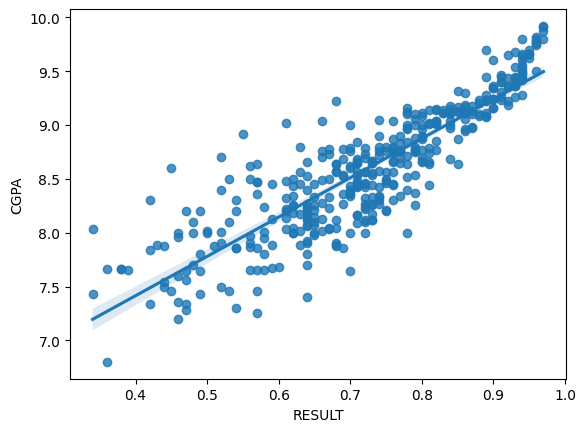

In [11]:
sns.regplot(data=data, x="RESULT", y="CGPA") # ad 3.

VYSVĚTLOVANÁ PROMĚNNÁ

1. Naší vysvětlovanou proměnnou bude "šance na přijetí" - vytvořte boxplot pro tuto proměnnou, aby bylo možné vizuálně identifikovat případné odlehlé hodnoty
2. Odstraňte odlehlá pozorování na základě kritérií zjištěných z boxplotu

<Axes: xlabel='RESULT'>

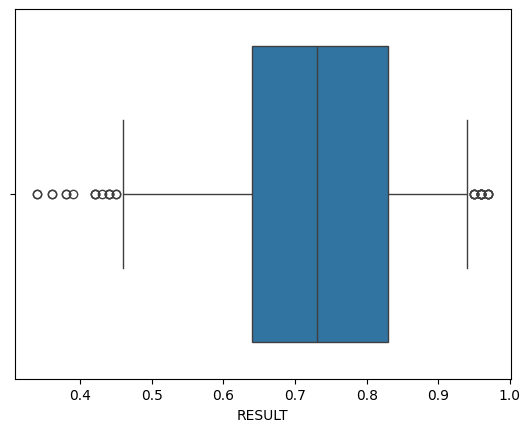

In [12]:
sns.boxplot(data, x="RESULT", whis=[5, 95]) # ad 1.

In [13]:
formula = "RESULT ~ ID + TOEFL + GRE + UNIRATING + SOP + LOR + CGPA + RESEARCH + RESULT"
mod = smf.ols(formula=formula, data=data)
results = mod.fit()
influence = OLSInfluence(results)
data['Cook Distance'] = influence.cooks_distance[0]
data.head()

,ID,GRE,TOEFL,UNIRATING,SOP,LOR,CGPA,RESEARCH,RESULT,Cook Distance
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.008429
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.006889
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.009827
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.008990
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.008399


In [18]:
data_updated = data[data['Cook Distance'] < 1] # ad 2.
mod = smf.ols(formula=formula, data=data_updated)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RESULT   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.881e+27
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        13:34:44   Log-Likelihood:                 12209.
No. Observations:                 400   AIC:                        -2.440e+04
Df Residuals:                     390   BIC:                        -2.436e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.551e-17   3.03e-14     -0.002      0.999   -5.96e-14    5.95e-14
ID         -1.139e-16   6.39e-18    -17.814      0.000   -1.26e-16   -1.01e-16
TOEFL       4.857e-17   2.38e-16      0.204      0.838   -4.19e-16    5.16e-16
GRE         6.462e-17   1.29e-16      0.501      0.617   -1.89e-16    3.18e-16
UNIRATING  -2.862e-17   1.03e-15     -0.028      0.978   -2.05e-15    1.99e-15
SOP         1.735e-17   1.19e-15      0.015      0.988   -2.33e-15    2.36e-15
LOR         3.123e-17   1.21e-15      0.026      0.979   -2.34e-15     2.4e-15
CGPA       -1.665e-16   2.91e-15     -0.057      0.954   -5.88e-15    5.55e-15
RESEARCH   -1.284e-16   1.72e-15     -0.075      0.940   -3.51e-15    3.25e-15
RESULT         1.0000   1.12e-14   8.92e+13      0.000       1.000       1.000
==============================================================================
Omnibus:                      221.847   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.597
Skew:                           0.005   Prob(JB):                     7.51e-06
Kurtosis:                       1.810   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LINEÁRNÍ REGRESE

1. Sestavte rovnici pro lineární regresi. Do rovnice zahrňte všechny proměnné které dávají smysl - viz níže
2. Odhadněte parametry lineárního regresního modelu - viz níže
3. Interpretujte koeficienty modelu. Které koeficienty jsou statisticky významné? Které proměnné mají největší vliv na šance na přijetí a proč?
    - koeficienty: ID, TOEFL, GRE, UNIRATING, SOP, LOR, CGPA, RESEARCH, RESULT
    - statisticky významné koeficienty (na 5% hladině významnosti) : TOEFL, GRE 

4. Vyhodnoťte kvalitu fitu vašeho lineárního regresního modelu pomocí koeficientu determinace R2 - R2=1 tudíž model lze vyhodnotit jako vhodný protože se nám podařilo vysvětlit 100% variability
5. Spočítejte Cookovu vzdálenost pro jednotlivé body - viz výše
6. histogram pro Cookovu vzdálenost - viz níže

y (vysvětlovaná proměnná)= b0 + b1x (x=vysvětlující proměnná)
    koeficienty: b0 - konstanta, 
                 b1 - směrnice přímky

RESULT = intercept + ID.x1 + TOEFL.x2 + GRE.x3 + UNIRATING.x4 + SOP.x5 + LOR.x6 + CGPA.x7 + RESEARCH.x8

<Axes: xlabel='Cook Distance', ylabel='Count'>

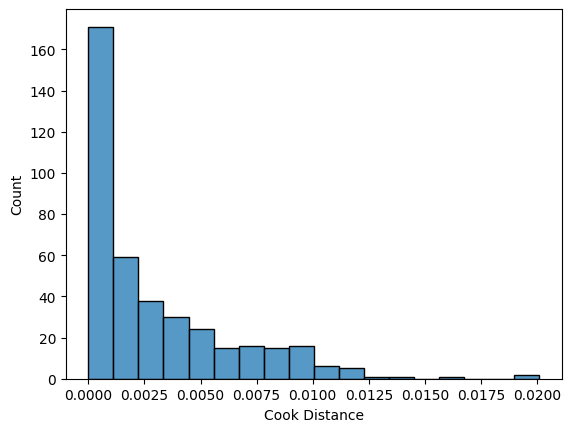

In [23]:
sns.histplot(data=data, x="Cook Distance")  #odstranila bych body s Cook.vzdáleností > 1